# Explorando datos públicos de combustibles

La [Comisión Nacional de Energía](https://www.cne.cl) es el único organismo estatal a la fecha que cuenta con una API para publicar precios. Habiendo obtenido credenciales para su uso, podemos utilizar Python para visualizar los datos de gasolinas, gases (glp y gnc) y diesel. Otra API da precios de parafina y gas licuado domiciliario. Para las estaciones de servicio se cuenta también con información de las dependencias disponibles (farmacia, tienda, mantención). Por ahora nos enfocaremos en los precios del combustible.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

off_vars =['farmacia','mantencion','fecha_hora_actualizacion','autoservicio']   # excluidas por ahora
gas = pd.read_csv('http://quant.cl/static/CSVS/gasprices.csv')  #.drop(off_vars,axis=1) 
#gas = gas[gas['petroleo diesel']<1000]                                          # eliminamos error humano
gas = gas.rename(columns={('gasolina %s' %ix): int(ix) for ix in ['93','95','97']})     # etiquetado
gas = gas.rename(columns={'glp vehicular': 'glp', 'petroleo diesel': 'diesel', 
                          'nombre_comuna': 'comuna'})
print(gas.fecha_hora_actualizacion.max())
gas = gas[['id_region','comuna','direccion_calle','latitud','longitud',93,95,97,'diesel','glp','gnc']]

gas.sample(10)

2018-06-02 23:30:03


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id_region,comuna,direccion_calle,latitud,longitud,93,95,97,diesel,glp,gnc
36461,5,Valparaíso,CHACABUCO,-33.046479,-71.606752,764.0,801.0,866.0,548.0,NaN,NaN
32119,13,La Florida,REAL ALICANTE,-33.516540,-70.583226,776.0,807.0,840.0,570.0,445.0,NaN
18085,14,La Unión,Av. Fischer esq. Grob,-40.297506,-73.080261,811.0,839.0,866.0,590.0,NaN,NaN
30613,13,Colina,Carretera General San Martín,-33.314678,-70.704618,809.0,840.0,871.0,603.0,NaN,NaN
7797,7,Maule,CARRETERA PANAMERICANA SUR KM,-35.531598,-71.687722,770.0,798.0,845.0,558.0,NaN,NaN
23385,13,Tiltil,Emilio Valle,-33.082576,-70.928208,726.0,761.0,796.0,520.0,NaN,NaN
4172,7,Empedrado,Arturo Prat esquina Alcerreca SN,-35.590223,-72.279975,790.0,NaN,860.0,560.0,NaN,NaN
21546,13,Pirque,Virginia Subercaseaux,-33.648144,-70.605947,792.0,827.0,861.0,577.0,NaN,NaN
1461,13,Peñalolén,Tobalaba,-33.504983,-70.561479,774.0,810.0,850.0,572.0,NaN,NaN
5855,6,Rancagua,O`Higgins Balmaceda,-34.167074,-70.731311,802.0,834.0,865.0,592.0,NaN,NaN


Vemos de inmediato que en Iquique, hay estaciones donde no se expende glp ni gnc. Veamos los promedios por región, ajustados por la media nacional y ordenados por la diferencia en el precio de la gasolina 93 (con respecto a la media)

In [ ]:
means = gas.groupby(['id_region']).mean().round(1)
means = means[[c for c in means.columns if c not in ['latitud','longitud']]]
desvios = 100*(means-means.mean())/means.mean()
desvios.round(1).fillna('N/A').sort_values(93)
means.head()

,93,95,97,diesel,glp,gnc
id_region,,,,,,
1,805.7,829.5,860.0,573.4,437.3,NaN
2,805.2,837.6,866.2,585.6,477.6,609.0
3,791.8,823.4,855.9,581.8,474.8,NaN
4,792.2,824.0,860.2,578.8,459.3,NaN
5,781.9,815.6,855.1,566.7,424.1,NaN


Podemos observar de inmediato que los precios de la gasolina tradicional (93,95,97, diesel) son fuertemente castigados fuera de la Región Metropolitana. El diesel es más barato en la 7ma Región. El glp tiene su valor más bajo en la 5ta Región y el gas natural comprimido (GNC) sólo se vende en la RM y en la 12ava. Si lo sacamos del análisis, podemos visualizar un mapa de calor a nivel nacional:

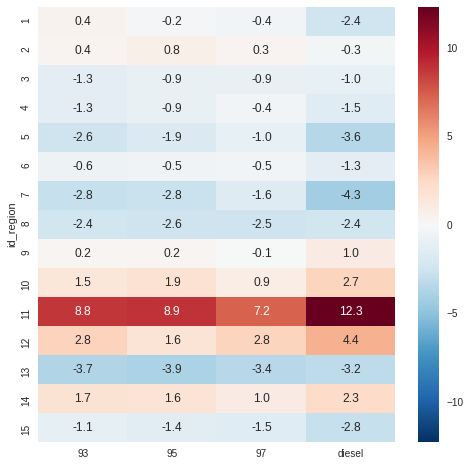

In [ ]:
#@title Desvío Porcentual Precio Gasolinas
gasolinas = desvios[[93,95,97,'diesel']]
fig,ax = plt.subplots(figsize=(8,8))
_=sns.heatmap(gasolinas,annot=True,fmt='.1f')

Vemos cómo el combustible vehicular más tradicional tiene un precio en torno al 8% más caro en la Región de Aisén (pero menos en Magallanes (subsidio?)). También destaca el bajo precio del diesel en la Región de O'Higgins, tendencia que observamos desde hace dos años según [estudios](https://www.cne.cl/estadisticas/hidrocarburo/) de la CNE. Desglosemos este mismo quiebre por comuna para una región dada.

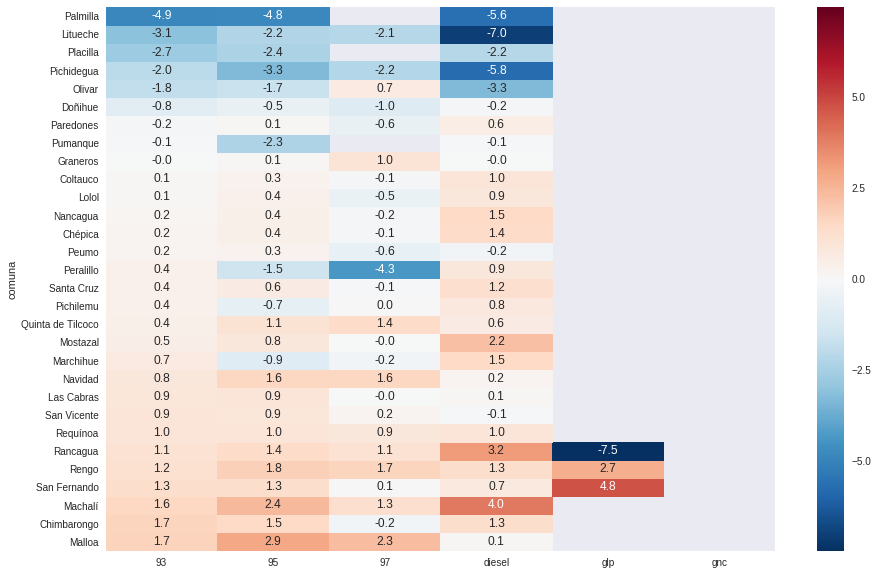

In [ ]:
#@title Variación Porcentual por Comuna
region=6 #@param {type:"slider", min:1, max:15}
gases = True #@param {type:"boolean"}
gas_region=gas[gas.id_region==region].drop(['latitud','longitud','id_region'],axis=1)
if gases == False: gas_region = gas_region.drop(['glp','gnc'],axis=1)
#print(gas_region.head())
promedios=gas_region.groupby('comuna').mean()
desvios_region=100*(promedios-promedios.mean())/promedios.mean()   # desvio_relativo
desvios_region=desvios_region.sort_values(93)

fig,ax=plt.subplots(figsize=(15,10))
_=sns.heatmap(desvios_region,annot=True,fmt='.1f')


En Santiago podemos ver que los precios más caros están en el sector oriente de la capital (Vitacura, Las Condes y Barnechea), pero también en otras comunas "periféricas" como Colina, Huechuraba, Buin y Paine. Veamos un mapa de calor geográfico.

In [ ]:
!pip install --quiet folium
import folium
from folium.plugins import HeatMap
region=13
full_region = gas[gas.id_region==region]
centroide=full_region[['latitud','longitud']].median().tolist()
llg = full_region[['comuna','latitud','longitud',93]] 
llg[93]=llg[93]-llg[93].min()
data=llg.groupby('comuna').mean()
data = data.dropna()
#data
fm = folium.Map(location=centroide, width=1000, height=500)
HeatMap(data.values.tolist(),max_val=50,radius=20,blur=1).add_to(fm)
folium.LayerControl(collapsed=False).add_to(fm)
fm

#data.sort_values(93)
#d93=data[93]
#d93.describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Visualicemos las codependencias de los valores numéricos. En la diagonal vemos un estimador de la densidad de cada variable.

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


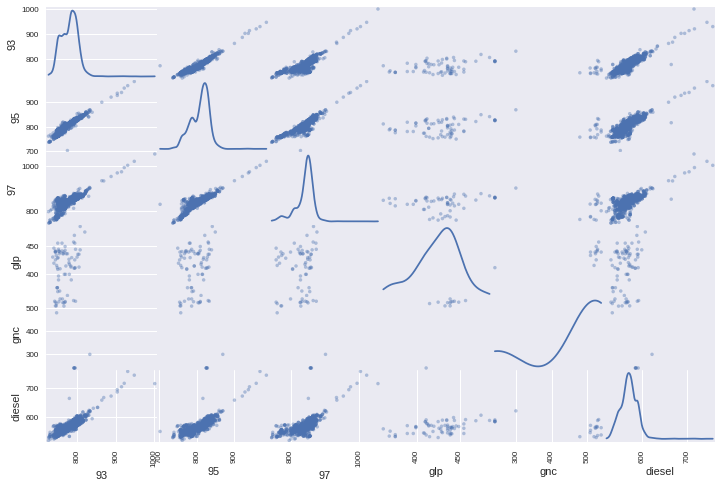

In [ ]:
dgas = gas[[93,95,97,'glp','gnc','diesel']]
fig, ax = plt.subplots(figsize=(12, 8)) 
_ = pd.plotting.scatter_matrix(dgas, alpha=0.4,diagonal='kde', ax=ax)

Ahora podemos visualizar estadísticas sobre cada variable (media, cuartiles, desviación estándar). "count" corresponde al número de datos válidos (!= N/A).

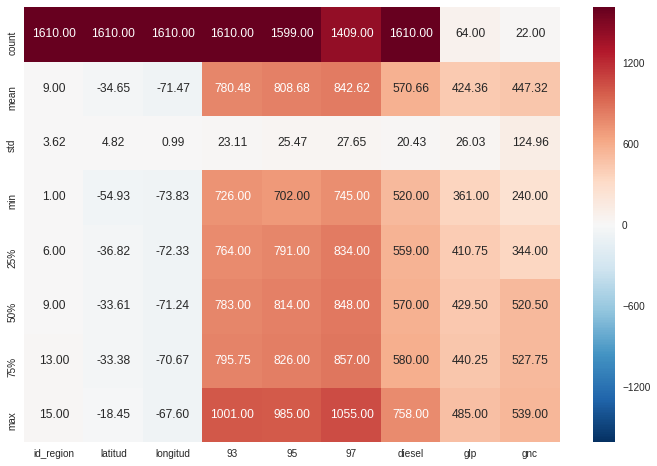

In [ ]:
stats = gas.describe()
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 8)) 
_=sns.heatmap(stats, annot=True, fmt=".2f", ax = ax)
#print(gas.std()/gas.mean())


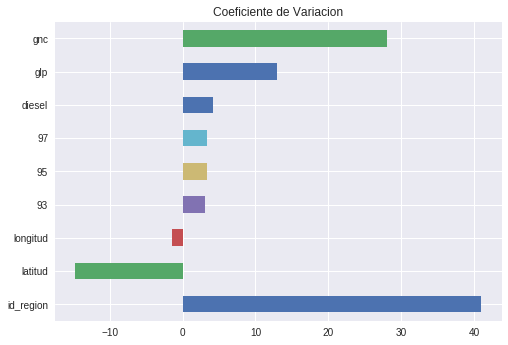

In [ ]:
#!pip install folium
out = gas
variacion = 100*out.std()/out.mean()
ax=variacion.plot(kind='barh',title='Coeficiente de Variacion')
#type(variacion)

Visualicemos las estaciones de la Región de los Ríos (X).

In [ ]:
#@title Mapa bencineras por región
#!pip install folium
import folium
#gas.head()
region=13 #@param {type:'slider',min:1,max:15,step:1}
df = gas[gas.id_region==region]
fm = folium.Map(location=df[['latitud','longitud']].mean().tolist(),zoom_start=8,
                tiles='Mapbox Control Room', width='50%', height='70%')
media = df.mean()
cscale = lambda x: 'green' if x<-10 else 'blue' if x<-2 else \
            'pink' if x>2 else 'red' if x>10 else 'white'
for did,drow in df.iterrows():     
  escala = round((drow-media).mean(),1)
  pop = str({'direccion':drow['direccion_calle'],
             'castigo':escala,             'comuna': drow['comuna']})
  
  folium.Circle(radius=1000, 
                color=cscale(escala),
                popup = 'precios:'+str((drow[93],drow[95],drow[97]))+'<BR> castigo:'+str(escala),
                location=(drow['latitud'],drow['longitud'])).add_to(fm)  
fm                  


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5799: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  return_indexers=True)


Una pregunta natural que surge es: cuánta gente vive a más de 50km de una gasolinera?

In [ ]:
!rm chile.db
import sqlite3, pandas as pd
pop = pd.read_csv('http://www.quant.cl/static/DATA/poblacion_2018.csv', names=['comuna','poblacion'])
pop.to_sql('poblacion', sqlite3.connect('chile.db'), index=False)
gpop.to_sql('gasolina', sqlite3.connect('chile.db'), index=False)


ValueError: ignored

In [ ]:
avg_gas = pd.read_sql('''SELECT com, AVG(latitud) AS lat, AVG(longitud) AS lon FROM gasolina \
                      GROUP BY com''', sqlite3.connect('chile.db'))
#pd.read_sql('SELECT P.comuna, latitud, longitud, G.poblacion FROM poblacion AS P, gasolina as G  WHERE P.comuna=G.com LIMIT 5', sqlite3.connect('chile.db'))
#pd.read_sql('SELECT P.comuna, P.poblacion, * FROM poblacion AS P, gasolina as G  WHERE P.comuna=G.com LIMIT 5', sqlite3.connect('chile.db'))
avg_gas.to_sql('gas_prom', sqlite3.connect('chile.db'))
avg_gas.sample(5)

,com,lat,lon
29,Cerrillos,-33.499083,-70.708170
41,Cisnes,-44.341939,-72.546980
218,Quirihue,-36.279283,-72.542483
42,Cobquecura,-36.134667,-72.796590
123,Los Andes,-32.830993,-70.596094


In [ ]:
conn = sqlite3.connect('chile.db')
pd.read_sql('SELECT comuna, poblacion, lat, lon FROM poblacion AS P, gas_prom AS G WHERE com=comuna ORDER BY poblacion DESC LIMIT 5', conn) # 

,comuna,poblacion,lat,lon
0,Puente Alto,633021,-33.588737,-70.579667
1,Maipú,563499,-33.507574,-70.759740
2,Antofagasta,395453,-23.632254,-70.386090
3,La Florida,390164,-33.537958,-70.588846
4,Viña del Mar,328241,-33.011039,-71.538673
